# 3D_HOUSES

## Import all libraries

In [110]:
from glob import glob
from typing import Tuple, List
import natsort
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import plotly.graph_objects as go
import plotly.io as pio 
import pandas as pd

import json
import requests

import geopandas as gpd
import rasterio
import rioxarray as rxr
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union

## Widgets

In [111]:
dropdown_address = widgets.Dropdown(
    options=['Sint-Pietersplein 9 Gent 9000', 
            'Sint-Pietersplein 16 Gent 9000', 
            'Lange Nieuwstraat 73 Antwerpen 2000',
            'Abrahamstraat 15 Gent 9000',
            'Quinten Matsijslei 25 Antwerpen 2018'],
    value='Quinten Matsijslei 25 Antwerpen 2018',
    description='Address:',
    disabled=False,
)

button = widgets.Button(
    description='3D Plot',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='cube'
)

dropdown_cut = widgets.Dropdown(
    options=[('Polygon clipping', True), ('Square clipping', False)],
    value=True,
    description='Clip:',
    disabled=False,
)

dropdown_renderer = widgets.Dropdown(
    options=[('Mayavi', render_3D), ('Plotly', render_3D_2)],
    value=render_3D_2,
    description='Renderer:',
    disabled=False,
)

def main(b):
    data = load_data(DSM_path, DTM_path)
    coord = fetch_coord(dropdown_address.value)
    tif_index = find_tif(data, coord)
    poly = find_polygon(coord, shp_paths)
    DSM_clip, DTM_clip = crop_tif(data, tif_index, poly, shape_cut=dropdown_cut.value)
    CHM = CHMer(DSM_clip, DTM_clip)
    dropdown_renderer.value(CHM)
    
button.on_click(main)

items = [dropdown_address, dropdown_cut, dropdown_renderer, button]

## Paths

In [112]:
DSM_path = "/Volumes/Samsung T7/DSM/**/*.tif"
DTM_path =  "/Volumes/Samsung T7/DTM/**/*.tif"

shp_paths = ["/Volumes/Samsung T7/CADASTRE DATA/Belgium_L72_2020/Bpn_CaBu.shp", "/Volumes/Samsung T7/CADASTRE DATA/Belgium_L72_2020/Bpn_ReBu.shp"]

## Create a dictionary of GTiff's paths and bounds

In [113]:
def load_data(DSM_path:str, DTM_path:str) -> dict:
    
    data = {}
    data['DSM_list'] = natsort.natsorted([file for file in glob(DSM_path, recursive=True)])
    data['DTM_list'] = natsort.natsorted([file for file in glob(DTM_path, recursive=True)])
    data['bounds'] = []
    
    for path in data['DSM_list']:
        with rasterio.open(path, driver="GTiff") as tif:
            data['bounds'].append(np.array(tif.bounds))

    return data

In [114]:
data = load_data(DSM_path, DTM_path)
data

{'DSM_list': ['/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k01/GeoTIFF/DHMVIIDSMRAS1m_k01.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k02/GeoTIFF/DHMVIIDSMRAS1m_k02.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k03/GeoTIFF/DHMVIIDSMRAS1m_k03.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k04/GeoTIFF/DHMVIIDSMRAS1m_k04.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k05/GeoTIFF/DHMVIIDSMRAS1m_k05.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k06/GeoTIFF/DHMVIIDSMRAS1m_k06.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k07/GeoTIFF/DHMVIIDSMRAS1m_k07.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k22/GeoTIFF/DHMVIIDSMRAS1m_k22.tif'],
 'DTM_list': ['/Volumes/Samsung T7/DTM/DHMVIIDTMRAS1m_k01/GeoTIFF/DHMVIIDTMRAS1m_k01.tif',
  '/Volumes/Samsung T7/DTM/DHMVIIDTMRAS1m_k02/GeoTIFF/DHMVIIDTMRAS1m_k02.tif',
  '/Volumes/Samsung T7/DTM/DHMVIIDTMRAS1m_k03/GeoTIFF/DHMVIIDTMRAS1m_k03.tif',
  '/Volumes/Samsung T7/DTM/

## Fetching the L_72 coordinates from the API with address [CEREN]

In [115]:
def fetch_coord(address:str)  -> Point:
    
    response = requests.get(f"https://loc.geopunt.be/v4/location?q={address}")
    data = json.loads(response.content)
    
    long_x_lambert72 = data['LocationResult'][0]['Location']['X_Lambert72']
    lat_y_lambert72 = data['LocationResult'][0]['Location']['Y_Lambert72']
    
    return Point(float(long_x_lambert72),float(lat_y_lambert72))

In [116]:
coord = fetch_coord(dropdown_address.value)

## Find the relevant GTiff file containing the coordinates

In [117]:
def find_tif(data:dict, coord:Point) -> Tuple[str]:
    x, y = coord.xy
    for tif_index, bounds in enumerate(data['bounds']):
        x_min, y_min, x_max, y_max = bounds
        if (x_min < x < x_max) and (y_min < y < y_max):
            return tif_index

In [118]:
tif_index = find_tif(data, coord)
tif_index

7

## Find the polygon containing the coordinates

In [119]:
def find_polygon(coord:Point, shp_paths:List[str]):

    for path in shp_paths:
        try:
            check_poly = gpd.read_file(path, mask=coord).geometry[0]
            polys = [poly for poly in gpd.read_file(path, mask=coord).geometry]
            poly = cascaded_union(polys)
            break
        except:
            continue
    return poly

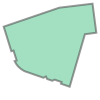

In [120]:
poly = find_polygon(coord, shp_paths)
poly

## Crop DSM & DTM

In [121]:
def crop_tif(data, tif_index, poly, shape_cut=dropdown_cut.value):
    
    DSM = rxr.open_rasterio(data['DSM_list'][tif_index],masked=True)
    DTM = rxr.open_rasterio(data['DTM_list'][tif_index],masked=True)

    left, bottom, right, top = poly.bounds
    DSM_clip = DSM.rio.clip_box(left, bottom, right, top)
    DTM_clip = DTM.rio.clip_box(left, bottom, right, top)

    if shape_cut:
        DSM_clip = DSM_clip.rio.clip([poly.__geo_interface__])
        DSM_clip = np.nan_to_num(DSM_clip, nan=0)

        DTM_clip = DTM_clip.rio.clip([poly.__geo_interface__])
        DTM_clip = np.nan_to_num(DTM_clip, nan=0)
    
    DSM.close()
    DTM.close()
    
    return DSM_clip, DTM_clip

In [122]:
DSM_clip, DTM_clip = crop_tif(data, tif_index, poly, shape_cut=True)

## Create CHM from DSM & DTM

In [123]:
def CHMer(DSM_clip, 
          DTM_clip):
    return DSM_clip - DTM_clip

In [124]:
CHM = CHMer(DSM_clip, DTM_clip)

## Outputing property's information [ATEFEH]

In [125]:
property = {}
property["Max_height"] = np.max(CHM.data)
property["Estimated surface area"] = poly.area * 0.7 # Roughly 70% of built-area is living area https://www.quora.com/How-do-I-calculate-the-number-of-floors-to-be-built
property["Estimated Max number of floors"] = int(property["Max_height"] / 3.3)
property["Upper limit of living area"] = property["Estimated Max number of floors"] * property["Estimated surface area"]
property

{'Max_height': 31.117226,
 'Estimated surface area': 593.8211757819807,
 'Estimated Max number of floors': 9,
 'Upper limit of living area': 5344.390582037827}

## 3D Rendering [CORENTIN]

In [126]:
#from mayavi import mlab

In [127]:
def render_3D_2(CHM_clip):
    '''
    ©Harold, thanks for the tip ! 
    '''
    pio.renderers.default='browser' 
    arr = CHM_clip.squeeze().data
    arr = np.pad(arr, [(5, ), (5, )], mode='constant')
    clipped_df = pd.DataFrame(arr)

    fig = go.Figure(data=[go.Surface(z=clipped_df)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=False,
                                      highlightcolor="turquoise", project_z=True))
    fig.update_layout(title=dropdown_address.value, autosize=False,
                      scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                      width=700, height=700,
                      margin=dict(l=65, r=50, b=65, t=90)
    )

    fig.show()

## 3D Rendering [HUGO]

In [128]:
from mayavi import mlab
def render_3D(CHM_clip):
    arr = CHM_clip.squeeze().data
    arr = np.pad(arr, [(2, ), (2, )], mode='constant')
    mlab.figure(size=(640, 800), bgcolor=(0.16, 0.28, 0.46))
    surf = mlab.surf(arr)
    mlab.zlabel("Height")
    mlab.show()

## 3D Rendering inline

In [129]:
# from mayavi import mlab

In [130]:
#mlab.init_notebook()
#def render_3D_inline(CHM_clip):
#    arr = CHM_clip.squeeze().data
#    arr = np.pad(arr, [(2, ), (2, )], mode='constant')
#    mlab.figure(size=(640, 800), bgcolor=(0.16, 0.28, 0.46))
#    surf = mlab.surf(arr)
#    mlab.zlabel("Height")
#    return surf

## Showcasing MVP

In [131]:
widgets.Box(items)

Box(children=(Dropdown(description='Address:', index=4, options=('Sint-Pietersplein 9 Gent 9000', 'Sint-Pieter…